<a href="https://colab.research.google.com/github/hoshi0112/pytorch-YOLOv4/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 掛載雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gdown
import zipfile

# 下載dataset
url = 'https://drive.google.com/uc?id=1afvkz7WxnQu17eh6DY-ZLiSdDs9yw6PI'
output = 'HW2_dataset.zip'
gdown.download(url, output, quiet=False)

# 解壓縮
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/')


Downloading...
From (original): https://drive.google.com/uc?id=1afvkz7WxnQu17eh6DY-ZLiSdDs9yw6PI
From (redirected): https://drive.google.com/uc?id=1afvkz7WxnQu17eh6DY-ZLiSdDs9yw6PI&confirm=t&uuid=c461c47a-51d4-41b9-965d-a7923904a6f4
To: /content/HW2_dataset.zip
 21%|██        | 314M/1.50G [00:04<00:11, 99.8MB/s]

KeyboardInterrupt: 

# 1. 載入需要的 Module

In [ ]:
# pytorch 相關
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from torchvision import models
# 其他
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import copy
import os

In [ ]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


# 3. 數據預處理

設路徑

In [ ]:
model_path = '/content/sample_data/model.pth'
train_path = '/content/sample_data/HW2_dataset/training'
test_path = '/content/sample_data/HW2_dataset/testing'

只有做歸一化和固定大小128*128

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 4. 載入 Dataset

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image
import random
from collections import defaultdict

class NewDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

        if self.is_train:
            self.classes = os.listdir(root_dir)
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.classes = []
            self.class_to_idx = {}

        self.images = self.load_images()
        if self.is_train:
            self.undersample_images()

    def get_classes(self):
        return self.classes

    def get_labels(self):
        # 返回所有圖的標籤列表
        return [label for _, label in self.images]

    def load_images(self):
        images = []
        if self.is_train:
            for cls_name in self.classes:
                cls_dir = os.path.join(self.root_dir, cls_name)
                for img_name in os.listdir(cls_dir):
                    img_path = os.path.join(cls_dir, img_name)
                    images.append((img_path, self.class_to_idx[cls_name]))
        else:
            if os.path.isdir(self.root_dir):
                test_root_dir = self.root_dir
                for img_name in os.listdir(test_root_dir):
                    img_path = os.path.join(test_root_dir, img_name)
                    images.append((img_path, None))  # test_set不存label，使用 None 代替
            else:
                img_path = self.root_dir
                images.append((img_path, None))  # test_set

        return images

    def undersample_images(self):
        # under-sample 最多100張
        artist_images = defaultdict(list)
        for img_path, label in self.images:
            artist_images[label].append((img_path, label))

        undersampled_images = []
        for label, imgs in artist_images.items():
            if len(imgs) > 100:
                undersampled_images.extend(random.sample(imgs, 100))
            else:
                undersampled_images.extend(imgs)

        self.images = undersampled_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        img_name = os.path.basename(img_path)  # 获取图像文件名
        if self.is_train:
            return img, label
        else:
            return img, img_name  # 返回图像和图像名称



In [ ]:
# 創建數據集(驗證集和訓練集還沒分開)和測試集
dataset = NewDataset(train_path, train_transform, is_train=True)
test_dataset = NewDataset(test_path, test_transform, is_train=False)

檢查是否under-sampling

In [ ]:
# 取得訓練集的標籤
labels = dataset.get_labels()

# 检查 labels 变量内容
print(labels)  # 确保这是一个包含所有图像标签的列表

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

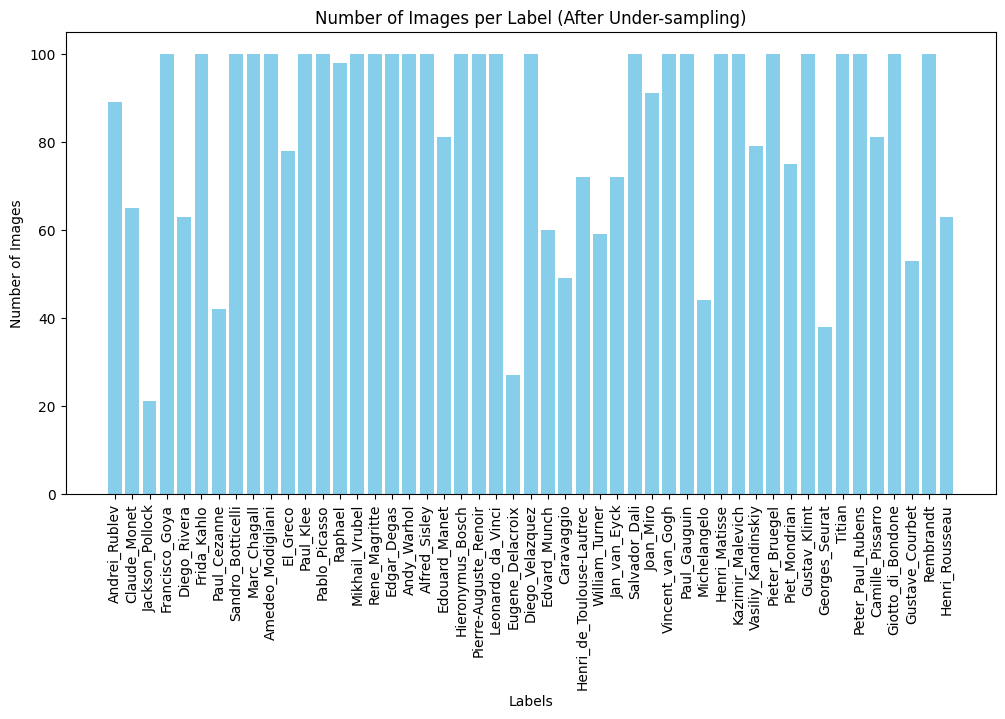

In [ ]:
from collections import Counter
# 統計每個的標籤數量
label_counts = Counter(labels)


label_names = [dataset.classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())


# 畫柱狀圖
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label (After Under-sampling)')
plt.xticks(rotation=90)
plt.show()

分訓練集和驗證集(9:1)

In [ ]:
train_size = 0.9
valid_size = 1-train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 5. 載入 Dataloader

訓練參數

In [ ]:
batch_size = 128
epochs = 10

In [ ]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True,num_workers=2)

檢查class紀錄狀況

In [ ]:
# 获取标签名称
classes = dataset.get_classes()
print(classes)

['Andrei_Rublev', 'Claude_Monet', 'Jackson_Pollock', 'Francisco_Goya', 'Diego_Rivera', 'Frida_Kahlo', 'Paul_Cezanne', 'Sandro_Botticelli', 'Marc_Chagall', 'Amedeo_Modigliani', 'El_Greco', 'Paul_Klee', 'Pablo_Picasso', 'Raphael', 'Mikhail_Vrubel', 'Rene_Magritte', 'Edgar_Degas', 'Andy_Warhol', 'Alfred_Sisley', 'Edouard_Manet', 'Hieronymus_Bosch', 'Pierre-Auguste_Renoir', 'Leonardo_da_Vinci', 'Eugene_Delacroix', 'Diego_Velazquez', 'Edvard_Munch', 'Caravaggio', 'Henri_de_Toulouse-Lautrec', 'William_Turner', 'Jan_van_Eyck', 'Salvador_Dali', 'Joan_Miro', 'Vincent_van_Gogh', 'Paul_Gauguin', 'Michelangelo', 'Henri_Matisse', 'Kazimir_Malevich', 'Vasiliy_Kandinskiy', 'Pieter_Bruegel', 'Piet_Mondrian', 'Gustav_Klimt', 'Georges_Seurat', 'Titian', 'Peter_Paul_Rubens', 'Camille_Pissarro', 'Giotto_di_Bondone', 'Gustave_Courbet', 'Rembrandt', 'Henri_Rousseau']


確定訓練集輸入(圖片長相、矩陣格式、label分布)

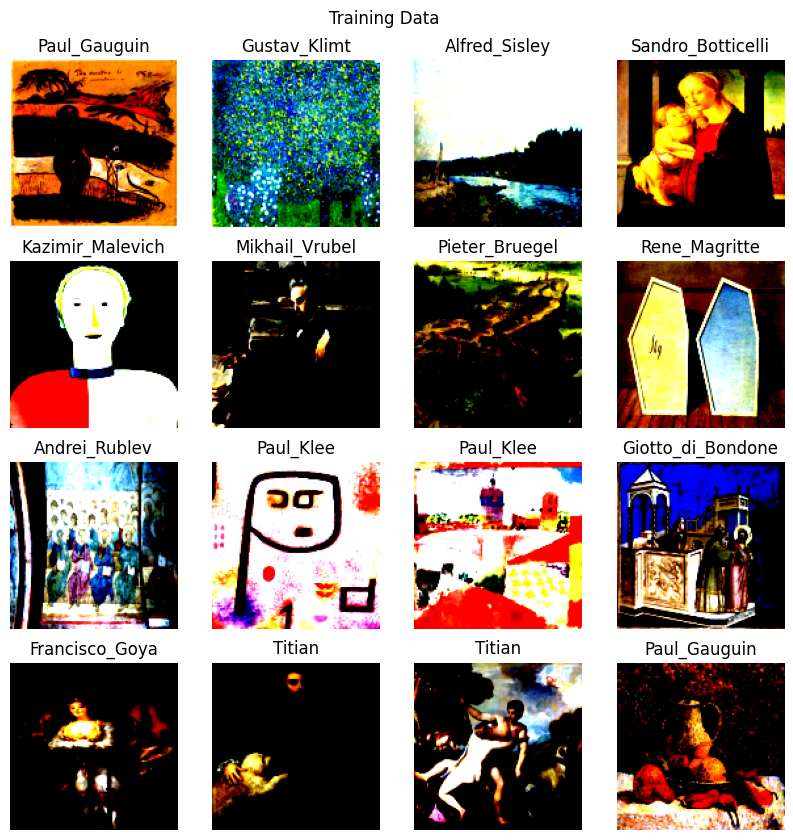

Batch Images Shape: torch.Size([128, 3, 128, 128])
Batch Labels: tensor([33, 40, 18,  7, 36, 14, 38, 15,  0, 11, 11, 45,  3, 42, 42, 33, 12, 30,
         0, 35, 19, 43, 17,  3, 42, 13, 32, 39, 42, 25, 33, 14, 11, 39, 31, 24,
        22, 46, 31, 37, 42, 30,  7, 14, 10, 40,  0, 13,  5, 46, 17, 41, 38,  8,
        38, 30, 34, 33, 33,  9,  3, 20,  3, 18, 19, 28,  6,  7, 11, 35, 21,  8,
        27, 26, 38, 27, 22, 17, 10, 27,  7,  5, 20,  8, 12, 41,  8, 22, 33, 40,
        18, 39, 10,  6, 21, 17,  3,  8, 34,  5, 17, 17,  1, 26, 24, 14, 19,  5,
        45, 47, 15,  5, 23, 14,  9, 14, 22, 32, 39, 29, 37, 29, 38, 23, 17,  9,
        33, 15])


In [ ]:
data_iterator = iter(train_loader)
inputs, labels = next(data_iterator)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i].numpy()  # Convert the tensor to a numpy array

    # Normalization based on the data type
    if img.dtype == np.float32:
        img = np.clip(img, 0, 1)  # Ensure the data is in the range [0, 1]
    elif img.dtype == np.int:
        img = np.clip(img, 0, 255)  # Ensure the data is in the range [0, 255]
        img = img / 255.0  # Normalize to [0, 1] for imshow

    # Convert from (channels, height, width) to (height, width, channels)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    title = classes[labels[i]]
    plt.title(title)
    plt.axis('off')

plt.suptitle('Training Data', y=0.93)
plt.show()

# print first batch data
print("Batch Images Shape:", inputs.shape)
print("Batch Labels:", labels)


確定驗證集輸入(圖片長相、矩陣格式、label分布)

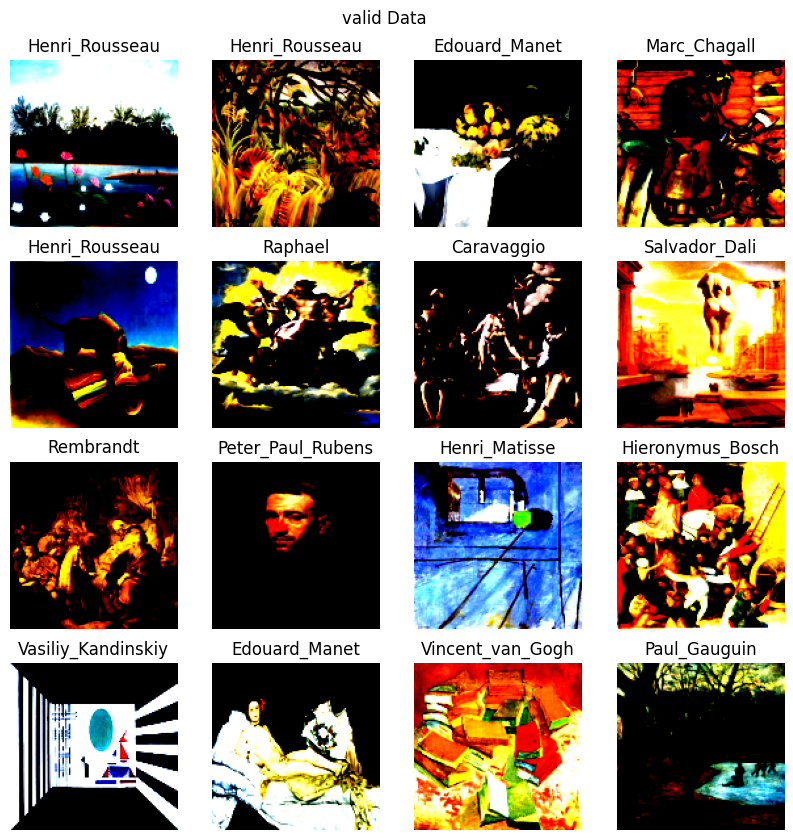

Batch Images Shape: torch.Size([128, 3, 128, 128])
Batch Labels: tensor([48, 48, 19,  8, 48, 13, 26, 30, 47, 43, 35, 20, 37, 19, 32, 33, 27, 15,
        30, 11, 17, 43, 29, 43, 40,  0, 19, 33, 46, 21, 11,  9,  0, 18, 45, 12,
        44, 20, 21, 15, 16, 12, 25, 13, 27,  7, 24, 45, 32,  5, 45, 27,  1, 46,
        10,  7, 18, 20, 43, 33, 44,  7, 47, 41, 30, 28,  9, 30, 48, 44,  3, 32,
        33, 37, 47, 39, 38, 38, 16, 11, 33, 13, 26, 35, 39, 45, 38, 13, 21, 44,
        21, 39, 48, 27, 43, 18, 25,  7, 31, 33, 25, 38, 29,  1, 48, 47, 12, 27,
        27, 13, 13, 39, 42, 48, 35, 39, 37, 15, 10, 39, 15, 13,  3, 14, 15, 17,
        15,  8])


In [ ]:
data_iterator = iter(valid_loader)
inputs, labels = next(data_iterator)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i].numpy()  # Convert the tensor to a numpy array

    # Normalization 確保數字在0到255之間(避免warning出現)
    if img.dtype == np.float32:
        img = np.clip(img, 0, 1)  # Ensure the data is in the range [0, 1]
    elif img.dtype == np.int:
        img = np.clip(img, 0, 255)  # Ensure the data is in the range [0, 255]
        img = img / 255.0  # Normalize to [0, 1] for imshow

    # Convert from (channels, height, width) to (height, width, channels)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    title = classes[labels[i]]
    plt.title(title)
    plt.axis('off')

plt.suptitle('valid Data', y=0.93)
plt.show()

# print first batch data
print("Batch Images Shape:", inputs.shape)
print("Batch Labels:", labels)

# 6. 定義模型

resnet152

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

# Store class names
class_names = dataset.classes

# Initialize model, loss function, and optimizer
model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)


印出架構

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

參數設置

變動學習率

In [ ]:
initial_lr = 0.01

# 定義優化器，使用 SGD 優化器，設置動量為 0.9
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)

# 定義學習率調整器，使用 StepLR 作為示例
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


loss function

In [ ]:
loss = nn.CrossEntropyLoss()

# 8. 開始訓練

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# Initializing variables
best_acc = 0.0
train_loss = []
train_acc = []
test_loss = []
test_acc = []

model = model.to(device)
model_path = "best_model.pth"  # Path to save the best model

for epoch in range(epochs):
    model.train()  # Set model to training mode

    train_epoch_loss = 0.0
    train_class_correct = [0 for _ in range(num_classes)]
    train_class_total = [0 for _ in range(num_classes)]

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute Loss & Update Weight
        batch_loss = loss(outputs, labels)
        if torch.isnan(batch_loss):
            print("NaN loss detected. Skipping batch.")
            continue

        batch_loss.backward()
        optimizer.step()

        train_epoch_loss += batch_loss.item()

        # Compute train_class_correct of each batch
        _, predicted = torch.max(outputs, 1)
        batch_correct = (predicted == labels)
        for j in range(len(labels)):
            label = labels[j]
            train_class_correct[label] += batch_correct[j].item()
            train_class_total[label] += 1

    # Compute Loss & Acc
    train_epoch_loss /= len(train_loader)
    train_epoch_accuracy = sum(train_class_correct) / sum(train_class_total) * 100

    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_accuracy)

    print(f'[Epoch: {epoch + 1}]')
    print(f'Train Accuracy of All: {train_epoch_accuracy:.3f} %')
    print(f'Train Loss of All: {train_epoch_loss:.3f}')
    print("----------------------------------------")

    # Validation class correct & class total
    val_loss = 0.0
    val_class_correct = [0 for _ in range(num_classes)]
    val_class_total = [0 for _ in range(num_classes)]

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute val_batch_loss
            batch_loss = loss(outputs, labels)
            if torch.isnan(batch_loss):
                print("NaN loss detected in validation. Skipping batch.")
                continue

            val_loss += batch_loss.item()

            # Compute val_class_correct of each batch
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels)
            for j in range(len(labels)):
                label = labels[j]
                val_class_correct[label] += batch_correct[j].item()
                val_class_total[label] += 1

    # Print each class accuracy of Validation
    for i in range(num_classes):
        if val_class_total[i] > 0:
            accuracy = 100 * val_class_correct[i] / val_class_total[i]
            print(f'Accuracy of {class_names[i]:5s}: {accuracy:.2f} %')

    # Compute Loss & Acc of Validation
    val_accuracy = sum(val_class_correct) / sum(val_class_total) * 100
    val_loss /= len(valid_loader)

    test_loss.append(val_loss)
    test_acc.append(val_accuracy)

    print(f'Validation Accuracy of All: {val_accuracy:.3f} %')
    print(f'Validation Loss of All: {val_loss:.3f}')
    print("----------------------------------------")

    # Save best model
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        torch.save(model.state_dict(), model_path)
    scheduler.step()
print('Finished Training')


[Epoch: 1]
Train Accuracy of All: 21.431 %
Train Loss of All: 3.197
----------------------------------------
Accuracy of Andrei_Rublev: 100.00 %
Accuracy of Claude_Monet: 33.33 %
Accuracy of Francisco_Goya: 50.00 %
Accuracy of Diego_Rivera: 16.67 %
Accuracy of Frida_Kahlo: 44.44 %
Accuracy of Paul_Cezanne: 0.00 %
Accuracy of Sandro_Botticelli: 80.00 %
Accuracy of Marc_Chagall: 44.44 %
Accuracy of Amedeo_Modigliani: 75.00 %
Accuracy of El_Greco: 50.00 %
Accuracy of Paul_Klee: 33.33 %
Accuracy of Pablo_Picasso: 14.29 %
Accuracy of Raphael: 84.62 %
Accuracy of Mikhail_Vrubel: 10.00 %
Accuracy of Rene_Magritte: 22.22 %
Accuracy of Edgar_Degas: 12.50 %
Accuracy of Andy_Warhol: 90.91 %
Accuracy of Alfred_Sisley: 84.62 %
Accuracy of Edouard_Manet: 42.86 %
Accuracy of Hieronymus_Bosch: 76.92 %
Accuracy of Pierre-Auguste_Renoir: 33.33 %
Accuracy of Leonardo_da_Vinci: 100.00 %
Accuracy of Diego_Velazquez: 55.56 %
Accuracy of Edvard_Munch: 0.00 %
Accuracy of Caravaggio: 33.33 %
Accuracy of Henri_

如果還沒收斂，可以用輸出的pth繼續跑

In [ ]:
# import torch

# # Paths and hyperparameters
# model_path = "/content/best_model.pth"  # Path to saved model
# additional_epochs = 10  # Number of additional epochs to train

# # Load the saved model weights
# model.load_state_dict(torch.load(model_path))

# # Move model to the correct device
# model = model.to(device)

# # Continue training for additional_epochs
# for epoch in range(additional_epochs):
#     model.train()  # Set model to training mode

#     train_epoch_loss = 0.0
#     train_class_correct = [0 for _ in range(num_classes)]
#     train_class_total = [0 for _ in range(num_classes)]

#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)

#         # Compute Loss & Update Weight
#         batch_loss = loss(outputs, labels)
#         if torch.isnan(batch_loss):
#             print("NaN loss detected. Skipping batch.")
#             continue

#         batch_loss.backward()
#         optimizer.step()

#         train_epoch_loss += batch_loss.item()

#         # Compute train_class_correct of each batch
#         _, predicted = torch.max(outputs, 1)
#         batch_correct = (predicted == labels)
#         for j in range(len(labels)):
#             label = labels[j]
#             train_class_correct[label] += batch_correct[j].item()
#             train_class_total[label] += 1

#     # Compute Loss & Acc
#     train_epoch_loss /= len(train_loader)
#     train_epoch_accuracy = sum(train_class_correct) / sum(train_class_total) * 100

#     train_loss.append(train_epoch_loss)
#     train_acc.append(train_epoch_accuracy)

#     print(f'[Epoch: {epoch + 1}]')
#     print(f'Train Accuracy of All: {train_epoch_accuracy:.3f} %')
#     print(f'Train Loss of All: {train_epoch_loss:.3f}')
#     print("----------------------------------------")

#     # Validation class correct & class total
#     val_loss = 0.0
#     val_class_correct = [0 for _ in range(num_classes)]
#     val_class_total = [0 for _ in range(num_classes)]

#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         for data in valid_loader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)

#             # Compute val_batch_loss
#             batch_loss = loss(outputs, labels)
#             if torch.isnan(batch_loss):
#                 print("NaN loss detected in validation. Skipping batch.")
#                 continue

#             val_loss += batch_loss.item()

#             # Compute val_class_correct of each batch
#             _, predicted = torch.max(outputs, 1)
#             batch_correct = (predicted == labels)
#             for j in range(len(labels)):
#                 label = labels[j]
#                 val_class_correct[label] += batch_correct[j].item()
#                 val_class_total[label] += 1

#     # Print each class accuracy of Validation
#     for i in range(num_classes):
#         if val_class_total[i] > 0:
#             accuracy = 100 * val_class_correct[i] / val_class_total[i]
#             print(f'Accuracy of {class_names[i]:5s}: {accuracy:.2f} %')

#     # Compute Loss & Acc of Validation
#     val_accuracy = sum(val_class_correct) / sum(val_class_total) * 100
#     val_loss /= len(valid_loader)

#     test_loss.append(val_loss)
#     test_acc.append(val_accuracy)

#     print(f'Validation Accuracy of All: {val_accuracy:.3f} %')
#     print(f'Validation Loss of All: {val_loss:.3f}')
#     print("----------------------------------------")

#     # Save best model
#     if val_accuracy > best_acc:
#         best_acc = val_accuracy
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'accuracy': best_acc,
#         }, model_path)

# print('Finished Training')


[Epoch: 1]
Train Accuracy of All: 99.810 %
Train Loss of All: 0.008
----------------------------------------
Accuracy of Andrei_Rublev: 75.00 %
Accuracy of Claude_Monet: 25.00 %
Accuracy of Jackson_Pollock: 100.00 %
Accuracy of Francisco_Goya: 54.55 %
Accuracy of Diego_Rivera: 42.86 %
Accuracy of Frida_Kahlo: 100.00 %
Accuracy of Paul_Cezanne: 25.00 %
Accuracy of Sandro_Botticelli: 41.67 %
Accuracy of Marc_Chagall: 90.00 %
Accuracy of Amedeo_Modigliani: 85.71 %
Accuracy of El_Greco: 75.00 %
Accuracy of Paul_Klee: 62.50 %
Accuracy of Pablo_Picasso: 11.11 %
Accuracy of Raphael: 63.64 %
Accuracy of Mikhail_Vrubel: 80.00 %
Accuracy of Rene_Magritte: 60.00 %
Accuracy of Edgar_Degas: 57.14 %
Accuracy of Andy_Warhol: 14.29 %
Accuracy of Alfred_Sisley: 66.67 %
Accuracy of Edouard_Manet: 16.67 %
Accuracy of Hieronymus_Bosch: 72.73 %
Accuracy of Pierre-Auguste_Renoir: 66.67 %
Accuracy of Leonardo_da_Vinci: 50.00 %
Accuracy of Eugene_Delacroix: 0.00 %
Accuracy of Diego_Velazquez: 27.27 %
Accuracy

KeyboardInterrupt: 

##結果可視化

Loss圖表

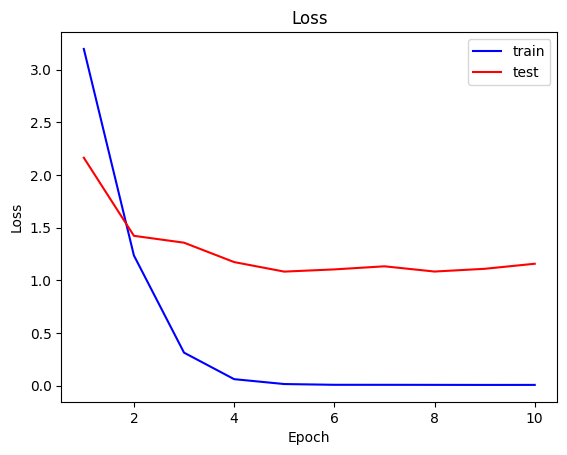

In [ ]:
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(i+1 for i in range(epochs)),train_loss, 'b')
plt.plot(list(i+1 for i in range(epochs)),test_loss, 'r')
plt.legend(['train','test'])
plt.show()

acc 圖表

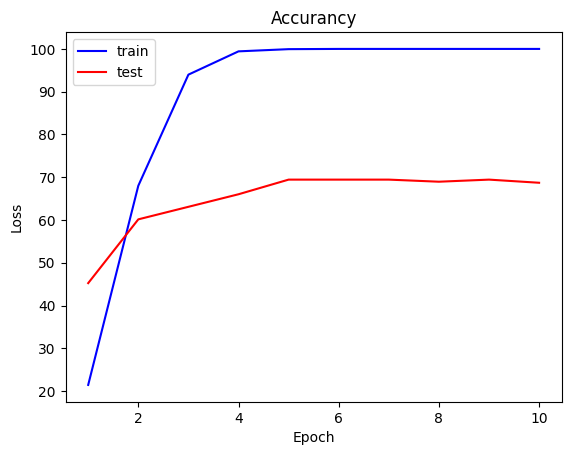

In [ ]:
plt.title("Accurancy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(i+1 for i in range(epochs)),train_acc, 'b')
plt.plot(list(i+1 for i in range(epochs)),test_acc, 'r')
plt.legend(['train','test'])
plt.show()

# 預測結果

把輸出的數字和人名作對應

In [ ]:
index_to_painter = {i: cls for i, cls in enumerate(classes)}

預測，結果存到Homework2.cvs

In [ ]:
import pandas as pd
# 加載訓練完的結果
model_path = '/content/best_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 預測
results = []

with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for image_name, pred in zip(image_names, preds):
            painter = index_to_painter[pred.item()]
            results.append({"image": image_name, "Painter": painter})

# .jpg按照數字排序
results.sort(key=lambda x: int(x["image"].split('.')[0]))

# 結果存到Homework2.csv
df = pd.DataFrame(results)
df.to_csv('Homework2.csv', index=False)